<a href="https://colab.research.google.com/github/dgiridaran/Learning_pytorch/blob/main/pytorch03_PyTorch_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Neural Network Classification

### 1. Make classification data and get it ready

Let's begin by making some data.

We'll use the `make_circles()` method from Scikit-Learn to generate two circles with different coloured dots.

---



In [1]:
from sklearn.datasets import make_circles

n_sample = 1000

X, y = make_circles(n_sample,
                    noise=0.03,
                    random_state=42)


In [2]:
print(f"first 5 X values: {X[:5]}")
print(f"first 5 y values: {y[:5]}")

first 5 X values: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
first 5 y values: [1 1 1 1 0]


In [3]:
import pandas as pd

In [4]:
circles = pd.DataFrame({"X1":X[:,0], "X2":X[:,1], "label":y})
circles.head()

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


In [5]:
circles.label.value_counts()

,count
label,
1,500
0,500


In [6]:
import matplotlib.pyplot as plt

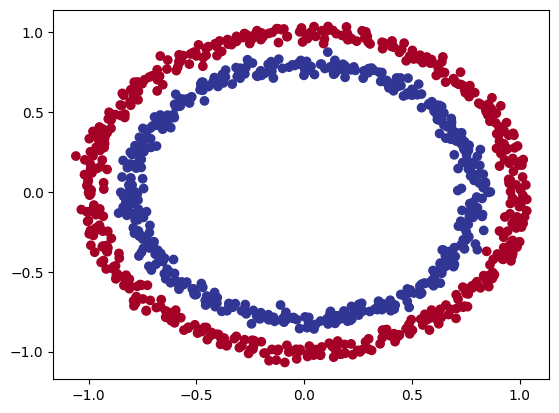

In [7]:
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)
plt.show()

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

## Turn data into tensors and create train and test splits

In [9]:
import torch

In [10]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [13]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Building a model

In [14]:
class CircleModelV0(nn.Module):

  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 features (X), produces 5 features
    self.layer_2 = nn.Linear(in_features=5, out_features=1)# takes in 5 features, produces 1 feature (y)

  def forward(self, x):
    return self.layer_2(self.layer_1(x)) # computation goes through layer_1 first then the output of layer_1 goes through layer_2

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

You can also do the same as above using `nn.Sequential`.

`nn.Sequential` performs a forward pass computation of the input data through the layers in the order they appear.

In [15]:
# Replicating CircleModel with nn.Sequential

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

Woah, that looks much simpler than subclassing nn.Module, why not just always use `nn.Sequential`?

`nn.Sequential` is fantastic for straight-forward computations, however, as the namespace says, it always runs in sequential order.

So if you'd like something else to happen (rather than just straight-forward sequential computation) you'll want to define your own custom nn.Module subclass.

Now we've got a model, let's see what happens when we pass some data through it.

In [16]:
untrained_pred = model_0(X_test.to(device))
print(f"Length of prediction: {len(untrained_pred)}, shape: {untrained_pred.shape}")
print(f"Length of Test Samples : {len(y_test)}, shape: {y_test.shape}")
print(f"First 10 predictions: {untrained_pred[:10]}")
print(f"First 10 test labels: {y_test[:10]}")

Length of prediction: 200, shape: torch.Size([200, 1])
Length of Test Samples : 200, shape: torch.Size([200])
First 10 predictions: tensor([[ 0.0857],
        [ 0.0543],
        [ 0.0989],
        [ 0.0822],
        [-0.0109],
        [-0.0292],
        [-0.0307],
        [-0.0505],
        [ 0.1035],
        [ 0.0509]], device='cuda:0', grad_fn=<SliceBackward0>)
First 10 test labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Hmm, it seems there are the same amount of predictions as there are test labels but the predictions don't look like they're in the same form or shape as the test labels.

We've got a couple steps we can do to fix this, we'll see these later on.

## 2.1 Setup loss function and optimizer

We've setup a loss (also called a criterion or cost function) and optimizer before in notebook 01.

But different problem types require different loss functions.

For example, for a regression problem (predicting a number) you might use mean absolute error (MAE) loss.

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, `torch.optim.SGD()`) can be used for a range of problems, and the same applies to the Adam optimizer (`torch.optim.Adam()`).



1.   Stochastic Gradient Descent (SGD) optimizer -->	Classification, regression, many others.	`torch.optim.SGD()`
2.   Adam Optimizer	--> Classification, regression, many others.	`torch.optim.Adam()`
3.  Binary cross entropy loss	Binary --> classification	`torch.nn.BCELossWithLogits` or `torch.nn.BCELoss`
4.  Cross entropy loss -->	Multi-class classification	`torch.nn.CrossEntropyLoss`
5.  Mean absolute error (MAE) or L1 Loss	Regression	`torch.nn.L1Loss`
6.  Mean squared error (MSE) or L2 Loss	Regression	`torch.nn.MSELoss`







**Note:** Recall a loss function is what measures how wrong your model predictions are, the higher the loss, the worse your model.

Also, PyTorch documentation often refers to loss functions as "loss criterion" or "criterion", these are all different ways of describing the same thing.

1. `torch.nn.BCELoss()` - Creates a loss function that measures the binary cross entropy between the target (label) and input (features).

2. `torch.nn.BCEWithLogitsLoss()` - This is the same as above except it has a sigmoid layer (nn.Sigmoid) built-in (we'll see what this means soon).

The documentation for `torch.nn.BCEWithLogitsLoss()` states that it's more numerically stable than using `torch.nn.BCELoss()` after a `nn.Sigmoid` layer.

So generally, implementation 2 is a better option. However for advanced usage, you may want to separate the combination of `nn.Sigmoid` and `torch.nn.BCELoss()` but that is beyond the scope of this notebook.

In [17]:
# Create a loss function
# loss_fn = nn.BCELoss() # BCELoss = no sigmoid built-in
loss_fn = nn.BCEWithLogitsLoss()  # BCEWithLogitsLoss = sigmoid built-in

# Creating an optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)


Now let's also create an **evaluation metric**.

In [18]:
# calculate accuracy (a clssification metric)

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item() # torch.eq() calculates where two tensors are equal
  acc = (correct / len(y_pred)) * 100
  return acc

## 3. Train model

Before the training loop steps, let's see what comes out of our model during the forward pass (the forward pass is defined by the forward() method).

To do so, let's pass the model some data.

In [19]:
y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[ 0.0857],
        [ 0.0543],
        [ 0.0989],
        [ 0.0822],
        [-0.0109]], device='cuda:0', grad_fn=<SliceBackward0>)

That's what our model is outputing above when it takes in the input data ($x$ in the equation or X_test in the code), logits.

However, these numbers are hard to interpret.

We'd like some numbers that are comparable to our truth labels.

To get our model's raw outputs (logits) into such a form, we can use the **sigmoid activation function**.

In [20]:
# using sigmoid on model logits

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5214],
        [0.5136],
        [0.5247],
        [0.5205],
        [0.4973]], device='cuda:0', grad_fn=<SigmoidBackward0>)


Okay, it seems like the outputs now have some kind of consistency (even though they're still random).

- If y_pred_probs >= 0.5, y=1 (class 1)
- If y_pred_probs < 0.5, y=0 (class 0)

To turn our prediction probabilities into prediction labels, we can round the outputs of the sigmoid activation function.

In [21]:
# Find the predicted labels (round the prediction probabilities)

y_pred = torch.round(y_pred_probs)

#in full
y_pred_full = torch.round(torch.sigmoid(model_0(X_test.to(device))))

# check for equality
print(torch.eq(y_pred.squeeze(), y_pred_full.squeeze()[:5]))

print(y_pred.squeeze())

tensor([True, True, True, True, True], device='cuda:0')
tensor([1., 1., 1., 1., 0.], device='cuda:0', grad_fn=<SqueezeBackward0>)


In [22]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

This means we'll be able to compare our model's predictions to the test labels to see how well it's performing.

To recap, we converted our model's raw outputs (logits) to prediction probabilities using a sigmoid activation function.

And then converted the prediction probabilities to prediction labels by rounding them.

**Note:** The use of the sigmoid activation function is often only for binary classification logits. For multi-class classification, we'll be looking at using the softmax activation function (this will come later on).

**And the use of the sigmoid activation function is not required when passing our model's raw outputs to the nn.BCEWithLogitsLoss (the "logits" in logits loss is because it works on the model's raw logits output), this is because it has a sigmoid function built-in.**

## 3.2 Building a training and testing loop

In [23]:
torch.manual_seed(42)

epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():

    test_logits = model_0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.5f}, Accuracy : {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.69392, Accuracy : 51.00% | Test loss: 0.69315, Test acc : 56.00%
Epoch : 10 | Loss : 0.69377, Accuracy : 50.12% | Test loss: 0.69303, Test acc : 54.00%
Epoch : 20 | Loss : 0.69368, Accuracy : 50.38% | Test loss: 0.69298, Test acc : 52.00%
Epoch : 30 | Loss : 0.69362, Accuracy : 50.25% | Test loss: 0.69295, Test acc : 50.50%
Epoch : 40 | Loss : 0.69357, Accuracy : 50.50% | Test loss: 0.69294, Test acc : 49.50%
Epoch : 50 | Loss : 0.69353, Accuracy : 51.25% | Test loss: 0.69294, Test acc : 49.50%
Epoch : 60 | Loss : 0.69349, Accuracy : 50.75% | Test loss: 0.69294, Test acc : 50.00%
Epoch : 70 | Loss : 0.69346, Accuracy : 50.75% | Test loss: 0.69295, Test acc : 50.00%
Epoch : 80 | Loss : 0.69343, Accuracy : 50.88% | Test loss: 0.69296, Test acc : 50.50%
Epoch : 90 | Loss : 0.69340, Accuracy : 50.75% | Test loss: 0.69298, Test acc : 49.50%


## 4. Make predictions and evaluate the model

From the metrics it looks like our model is random guessing.

How could we investigate this further?

I've got an idea.

The data explorer's motto!

"Visualize, visualize, visualize!"

Let's make a plot of our model's predictions, the data it's trying to predict on and the decision boundary it's creating for whether something is class 0 or class 1.

To do so, we'll write some code to download and import the helper_functions.py script from the Learn PyTorch for Deep Learning repo.

It contains a helpful function called plot_decision_boundary() which creates a NumPy meshgrid to visually plot the different points where our model is predicting certain classes.

We'll also import plot_predictions() which we wrote in notebook 01 to use later.

In [24]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

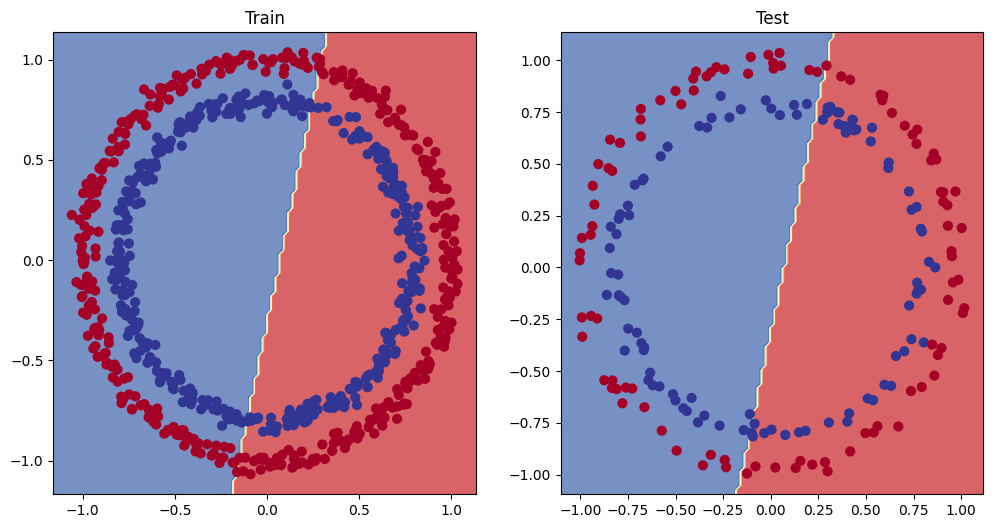

In [25]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

Oh wow, it seems like we've found the cause of model's performance issue.

It's currently trying to split the red and blue dots using a straight line...

That explains the 50% accuracy. Since our data is circular, drawing a straight line can at best cut it down the middle.

In machine learning terms, our model is underfitting, meaning it's not learning predictive patterns from the data.

How could we improve this?

## 5. Improving a model (from a model perspective)

Let's see what happens if we add an extra layer to our model, fit for longer (epochs=1000 instead of epochs=100) and increase the number of hidden units from 5 to 10.

We'll follow the same steps we did above but with a few changed hyperparameters.

In [26]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)

  def forward(self, x):

    return self.layer_3(self.layer_2(self.layer_1(x)))


model_1 = CircleModelV1().to(device)
model_1


CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [27]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.1)

In [28]:
torch.manual_seed(42)

epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_0.train()

  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_0.eval()

  with torch.inference_mode():

    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss : {loss:.5f}, Accuracy : {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc : {test_acc:.2f}%")

Epoch : 0 | Loss : 0.69396, Accuracy : 50.88% | Test loss: 0.69261, Test acc : 51.00%
Epoch : 100 | Loss : 0.69305, Accuracy : 50.38% | Test loss: 0.69379, Test acc : 48.00%
Epoch : 200 | Loss : 0.69299, Accuracy : 51.12% | Test loss: 0.69437, Test acc : 46.00%
Epoch : 300 | Loss : 0.69298, Accuracy : 51.62% | Test loss: 0.69458, Test acc : 45.00%
Epoch : 400 | Loss : 0.69298, Accuracy : 51.12% | Test loss: 0.69465, Test acc : 46.00%
Epoch : 500 | Loss : 0.69298, Accuracy : 51.00% | Test loss: 0.69467, Test acc : 46.00%
Epoch : 600 | Loss : 0.69298, Accuracy : 51.00% | Test loss: 0.69468, Test acc : 46.00%
Epoch : 700 | Loss : 0.69298, Accuracy : 51.00% | Test loss: 0.69468, Test acc : 46.00%
Epoch : 800 | Loss : 0.69298, Accuracy : 51.00% | Test loss: 0.69468, Test acc : 46.00%
Epoch : 900 | Loss : 0.69298, Accuracy : 51.00% | Test loss: 0.69468, Test acc : 46.00%


What? Our model trained for longer and with an extra layer but it still looks like it didn't learn any patterns better than random guessing.

Let's visualize.

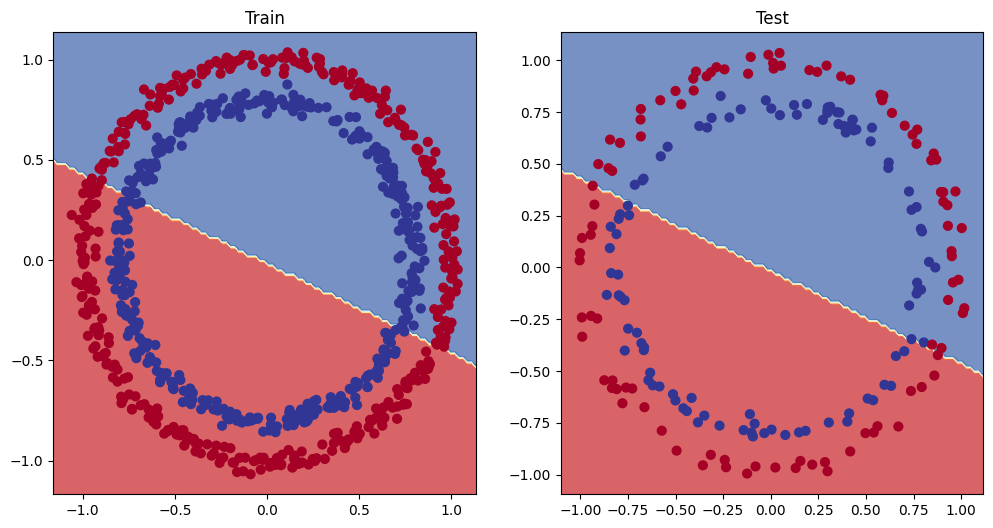

In [29]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

Hmmm.

Our model is still drawing a straight line between the red and blue dots.

If our model is drawing a straight line, could it model linear data? Like we did in notebook 01?

## 5.1 Preparing data to see if our model can model a straight line

In [30]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [31]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


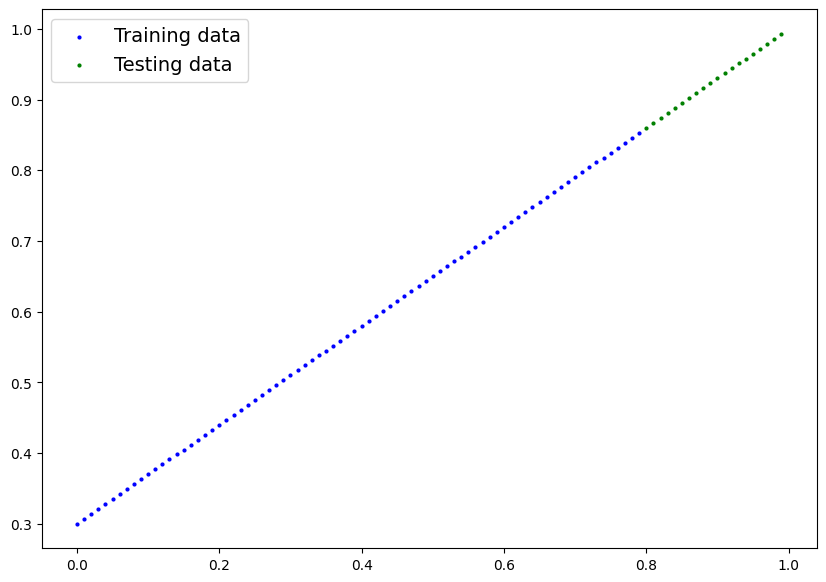

In [32]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

## 5.2 Adjusting model_1 to fit a straight line

In [33]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

We'll setup the loss function to be `nn.L1Loss()` (the same as mean absolute error) and the optimizer to be `torch.optim.SGD()`.

In [34]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [35]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


Okay, unlike model_1 on the classification data, it looks like model_2's loss is actually going down.

And remember, since our model and data are using the target device, and this device may be a GPU, however, our plotting function uses matplotlib and matplotlib can't handle data on the GPU.

To handle that, we'll send all of our data to the CPU using .cpu() when we pass it to plot_predictions().

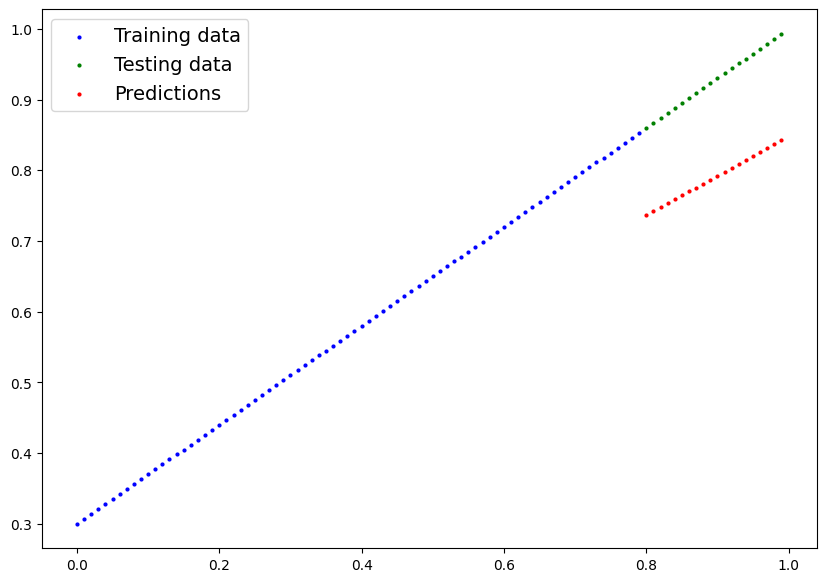

In [36]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

**Note:** A helpful troubleshooting step when building deep learning models is to start as small as possible to see if the model works before scaling it up.

This could mean starting with a simple neural network (not many layers, not many hidden neurons) and a small dataset (like the one we've made) and then overfitting (making the model perform too well) on that small example before increasing the amount of data or the model size/design to reduce overfitting.

## 6. The missing piece: non-linearity

#### 6.1 Recreating non-linear data (red and blue circles)

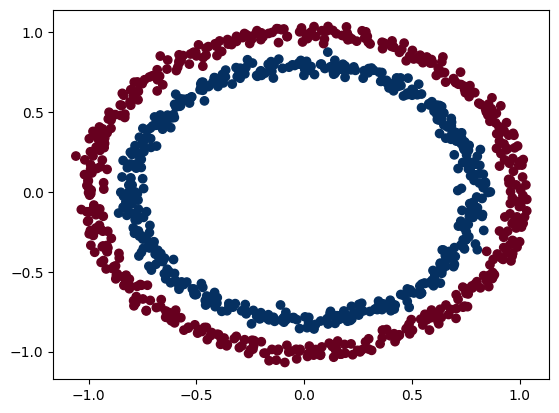

In [37]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [38]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

## 6.2 Building a model with non-linearity

What kind of pattern do you think you could draw with unlimited straight (linear) and non-straight (non-linear) lines?

I bet you could get pretty creative.

So far our neural networks have only been using linear (straight) line functions.

But the data we've been working with is non-linear (circles).

What do you think will happen when we introduce the capability for our model to use non-linear activation functions?

Well let's see.

PyTorch has a bunch of ready-made non-linear activation functions that do similar but different things.

One of the most common and best performing is ReLU) (rectified linear-unit, `torch.nn.ReLU()`).

In [39]:
class CircleModelV2(nn.Module):
    def __init__(self):
      super().__init__()
      self.layer_1 = nn.Linear(in_features=2, out_features=10)
      self.layer_2 = nn.Linear(in_features=10, out_features=10)
      self.layer_3 = nn.Linear(in_features=10, out_features=1)
      self.relu = nn.ReLU()# <- add in ReLU activation function
      # Can also put sigmoid in the model
      # This would mean you don't need to use it on the predictions
      # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))


model_3 = CircleModelV2().to(device)
print(model_3)



CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


**Question:** Where should I put the non-linear activation functions when constructing a neural network?

A rule of thumb is to put them in between hidden layers and just after the output layer, however, there is no set in stone option. As you learn more about neural networks and deep learning you'll find a bunch of different ways of putting things together. In the meantime, best to experiment, experiment, experiment.

In [40]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.01)

## 6.3 Training a model with non-linearity

In [41]:
torch.manual_seed(42)

epoachs = 10000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epoachs):
  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch : {epoch} | Loss: {loss:.5f}, Accuracy :{acc:.2f}% | Test Loss : {test_loss:.5f}, Test_accuracy : {test_acc:.2f}%")

Epoch : 0 | Loss: 0.69295, Accuracy :50.00% | Test Loss : 0.69325, Test_accuracy : 50.00%
Epoch : 100 | Loss: 0.69248, Accuracy :50.38% | Test Loss : 0.69264, Test_accuracy : 50.00%
Epoch : 200 | Loss: 0.69225, Accuracy :59.00% | Test Loss : 0.69233, Test_accuracy : 56.00%
Epoch : 300 | Loss: 0.69209, Accuracy :70.12% | Test Loss : 0.69214, Test_accuracy : 67.00%
Epoch : 400 | Loss: 0.69195, Accuracy :68.38% | Test Loss : 0.69197, Test_accuracy : 70.00%
Epoch : 500 | Loss: 0.69181, Accuracy :58.50% | Test Loss : 0.69179, Test_accuracy : 62.00%
Epoch : 600 | Loss: 0.69168, Accuracy :54.00% | Test Loss : 0.69163, Test_accuracy : 56.00%
Epoch : 700 | Loss: 0.69155, Accuracy :53.25% | Test Loss : 0.69148, Test_accuracy : 53.00%
Epoch : 800 | Loss: 0.69141, Accuracy :52.62% | Test Loss : 0.69133, Test_accuracy : 53.00%
Epoch : 900 | Loss: 0.69128, Accuracy :52.75% | Test Loss : 0.69118, Test_accuracy : 53.00%
Epoch : 1000 | Loss: 0.69115, Accuracy :53.00% | Test Loss : 0.69104, Test_accurac

## 6.4 Evaluating a model trained with non-linear activation functions

In [42]:
model_3.eval()
with torch.inference_mode():
  y_pred = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_pred[:10], y[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

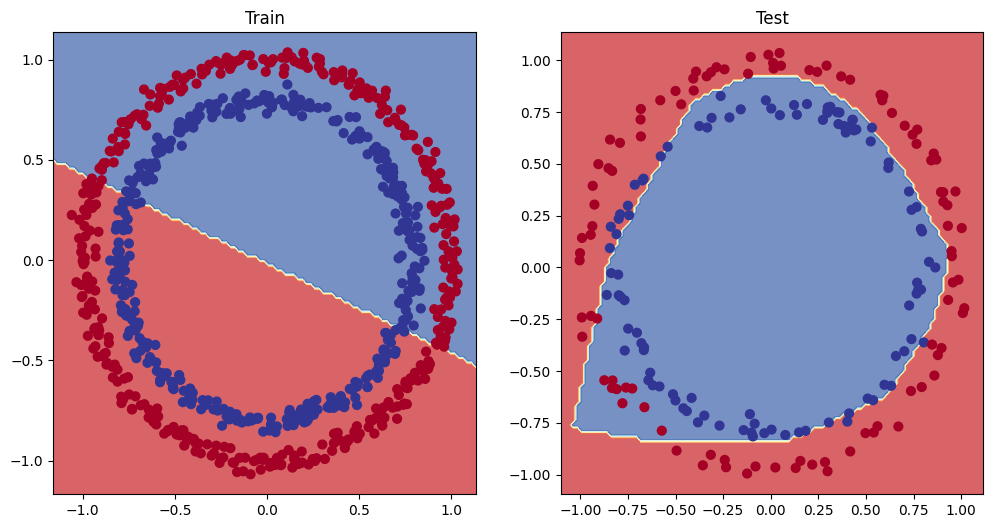

In [43]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

Nice! Not perfect but still far better than before.

Potentially you could try a few tricks to improve the test accuracy of the model? (hint: head back to section 5 for tips on improving the model)

## 7. Replicating non-linear activation functions

Let's start by creating a small amount of data.

In [44]:
A = torch.arange(-10, 10,1, dtype=torch.float32)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

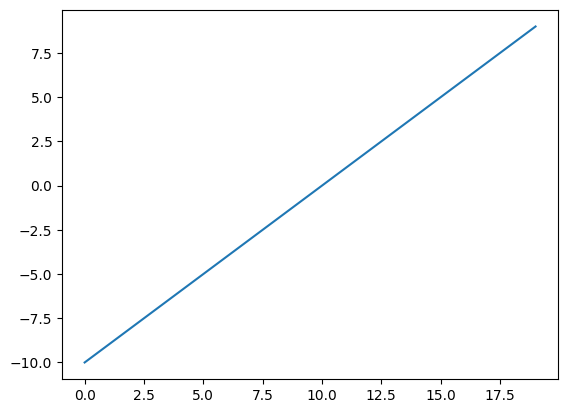

In [45]:
plt.plot(A)

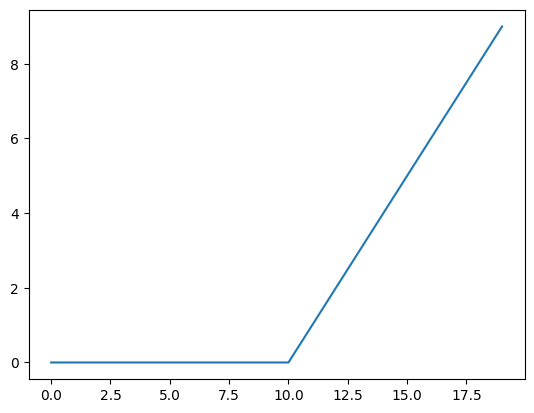

In [46]:
def relu(x):
  return torch.maximum(torch.tensor(0), x)

plt.plot(relu(A))

Let's build a function to replicate the sigmoid function with PyTorch

In [47]:
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

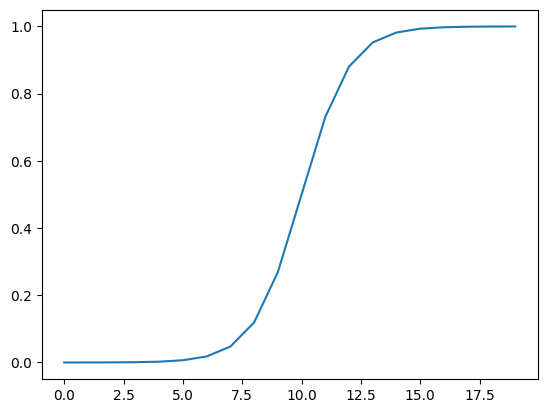

In [48]:
plt.plot(sigmoid(A));

Looking good! We've gone from a straight line to a curved line.

Now there's plenty more non-linear activation functions that exist in PyTorch that we haven't tried.

But these two are two of the most common.

And the point remains, what patterns could you draw using an unlimited amount of linear (straight) and non-linear (not straight) lines?

Almost anything right?

That's exactly what our model is doing when we combine linear and non-linear functions.

Instead of telling our model what to do, we give it tools to figure out how to best discover patterns in the data.

And those tools are linear and non-linear functions.

## 8. Putting things together by building a multi-class PyTorch model

But now let's put it all together using a multi-class classification problem.

Recall a **binary classification** problem deals with classifying something as one of two options (e.g. a photo as a cat photo or a dog photo) where as a **multi-class classification** problem deals with classifying something from a list of more than two options (e.g. classifying a photo as a cat a dog or a chicken).

### 8.1 Creating multi-class classification data

Specifically, let's do the following:

1. Create some multi-class data with `make_blobs()`.
Turn the data into tensors (the default of make_blobs() is to use NumPy arrays).
2. Split the data into training and test sets using train_test_split().
3. Visualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


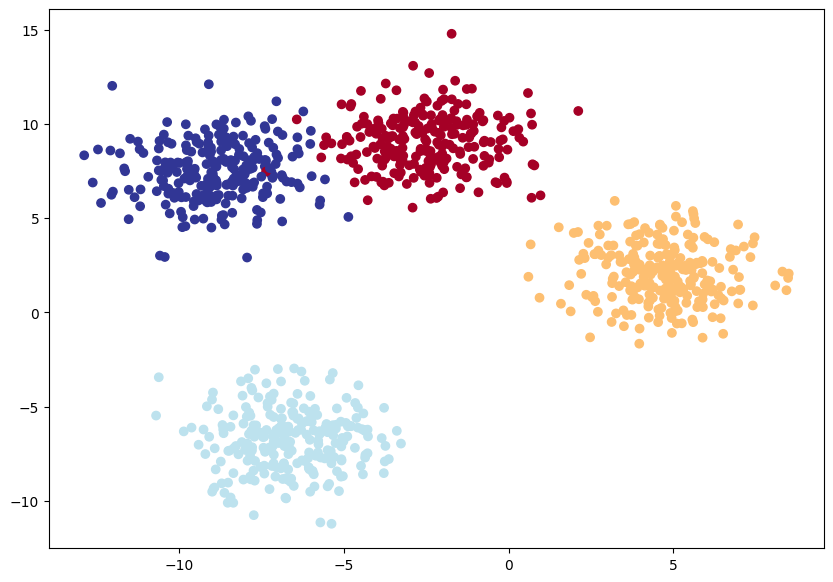

In [49]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])


X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob,
                                                                       test_size=0.2,
                                                                       random_state=RANDOM_SEED
                                                                       )
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

## 8.2 Building a multi-class classification model in PyTorch

In [50]:
from sys import int_info
from torch import nn

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_unites=8):
    super().__init__()
    self.linear_layers_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_unites),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_unites, out_features=hidden_unites),
        # nn.ReLU(),
        nn.Linear(in_features=hidden_unites, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layers_stack(x)


model_4 = BlobModel(input_features=NUM_FEATURES, output_features=NUM_CLASSES, hidden_unites=8).to(device)

model_4

BlobModel(
  (linear_layers_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

## 8.3 Creating a loss function and optimizer for a multi-class PyTorch model

Since we're working on a multi-class classification problem, we'll use the `nn.CrossEntropyLoss()` method as our loss function.

And we'll stick with using SGD with a learning rate of 0.1 for optimizing our `model_4` parameters.

In [51]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), lr=0.1)

## 8.4 Getting prediction probabilities for a multi-class PyTorch model
Alright, we've got a loss function and optimizer ready, and we're ready to train our model but before we do let's do a single forward pass with our model to see if it works.

In [52]:
model_4(X_blob_train.to(device))[:5]

tensor([[-1.2711, -0.6494, -1.4740, -0.7044],
        [ 0.2210, -1.5439,  0.0420,  1.1531],
        [ 2.8698,  0.9143,  3.3169,  1.4027],
        [ 1.9576,  0.3125,  2.2244,  1.1324],
        [ 0.5458, -1.2381,  0.4441,  1.1804]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [53]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

Wonderful, our model is predicting one value for each class that we have.

Do you remember what the raw outputs of our model are called?

Hint: it rhymes with "frog splits" (no animals were harmed in the creation of these materials).

If you guessed logits, you'd be correct.

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from **logits -> prediction probabilities -> prediction** labels just like we did with the binary classification problem?

That's where the **`softmax activation function**` comes into play.

The softmax function calculates the probability of each prediction class being the actual predicted class compared to all other possible classes.

If this doesn't make sense, let's see in code.

In [54]:
y_logits = model_4(X_blob_test.to(device))

y_pred_prob = torch.softmax(y_logits, dim=1)

print(y_logits[:5])
print(y_blob_test)
print(y_pred_prob[:5])

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
    

Hmm, what's happened here?

It may still look like the outputs of the softmax function are jumbled numbers (and they are, since our model hasn't been trained and is predicting using random patterns) but there's a very specific thing different about each sample.

After passing the logits through the softmax function, each individual sample now adds to 1 (or very close to).

In [55]:
y_pred_prob[0]

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)

In [56]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_prob[0])

tensor(1., device='cuda:0', grad_fn=<SumBackward0>)


These prediction probabilities are essentially saying how much the model thinks the target X sample (the input) maps to each class.

Since there's one value for each class in `y_pred_probs`, the index of the highest value is the class the model thinks the specific data sample most belongs to.

We can check which index has the highest value using `torch.argmax()`.

In [57]:
print(y_pred_prob[0])
print(torch.argmax(y_pred_prob[0]))

tensor([0.1872, 0.2918, 0.1495, 0.3715], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(3, device='cuda:0')


**Note:** To summarize the above, a model's raw output is referred to as logits.

For a multi-class classification problem, to turn the logits into prediction probabilities, you use the softmax activation function (`torch.softmax`).

The index of the value with the highest prediction probability is the class number the model thinks is most likely given the input features for that sample (although this is a prediction, it doesn't mean it will be correct).

## 8.5 Creating a training and testing loop for a multi-class PyTorch model

In [58]:
torch.manual_seed(42)

epoachs = 100

X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epoachs):
  y_logits = model_4(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_blob_train, y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_4(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_blob_test, test_pred)

  if epoch % 10 == 0:
    print(f"Epoch : {epoch} | Loss: {loss:.5f}, Accuracy :{acc:.2f}% | Test Loss : {test_loss:.5f}, Test_accuracy : {test_acc:.2f}%")

Epoch : 0 | Loss: 1.04324, Accuracy :65.50% | Test Loss : 0.57861, Test_accuracy : 95.50%
Epoch : 10 | Loss: 0.14398, Accuracy :99.12% | Test Loss : 0.13037, Test_accuracy : 99.00%
Epoch : 20 | Loss: 0.08062, Accuracy :99.12% | Test Loss : 0.07216, Test_accuracy : 99.50%
Epoch : 30 | Loss: 0.05924, Accuracy :99.12% | Test Loss : 0.05133, Test_accuracy : 99.50%
Epoch : 40 | Loss: 0.04892, Accuracy :99.00% | Test Loss : 0.04098, Test_accuracy : 99.50%
Epoch : 50 | Loss: 0.04295, Accuracy :99.00% | Test Loss : 0.03486, Test_accuracy : 99.50%
Epoch : 60 | Loss: 0.03910, Accuracy :99.00% | Test Loss : 0.03083, Test_accuracy : 99.50%
Epoch : 70 | Loss: 0.03643, Accuracy :99.00% | Test Loss : 0.02799, Test_accuracy : 99.50%
Epoch : 80 | Loss: 0.03448, Accuracy :99.00% | Test Loss : 0.02587, Test_accuracy : 99.50%
Epoch : 90 | Loss: 0.03300, Accuracy :99.12% | Test Loss : 0.02423, Test_accuracy : 99.50%


## 8.6 Making and evaluating predictions with a PyTorch multi-class model

In [59]:
model_4.eval()
with torch.inference_mode():
  y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0726,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2890],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5918, -18.5990,  25.5309,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]], device='cuda:0')

**Note:** It's possible to skip the torch.softmax() function and go straight from predicted logits -> predicted labels by calling torch.argmax() directly on the logits.

For example, y_preds = torch.argmax(y_logits, dim=1), this saves a computation step (no torch.softmax()) but results in no prediction probabilities being available to use.

In [61]:
y_pred_probs = torch.softmax(y_logits, dim=1)

y_preds = y_pred_probs.argmax(dim=1)

print(y_preds[:10], '\n', y_blob_test[:10])
print(accuracy_fn(y_blob_test, y_preds))

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0') 
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')
99.5


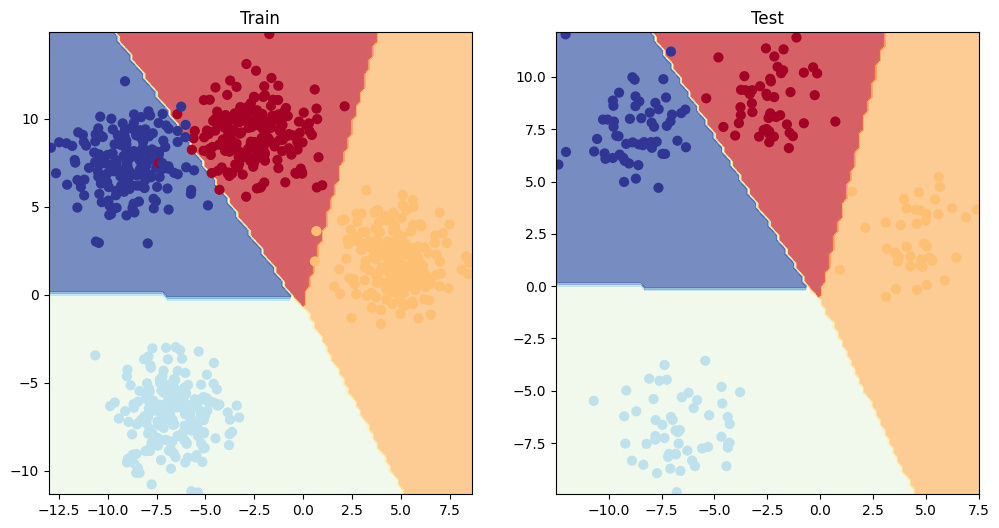

In [62]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)